# **Geração de texto**

Neste laboratório, vamos mergulhar no fascinante mundo da geração de texto usando Large Language Models (LLMs). O objetivo principal é desvendar o funcionamento dessas poderosas ferramentas e explorar conceitos-chave como tokenização, temperatura do modelo e otimização com KV-Cache.

**Objetivos de Aprendizagem:**

Ao final deste laboratório, os alunos serão capazes de:

* Entender o processo de tokenização e como ele influencia a geração de texto.
* Manipular a temperatura do modelo para controlar a criatividade e aleatoriedade do texto gerado.
* Implementar a otimização KV-Cache para acelerar a geração de texto.
* Avaliar a performance de diferentes modelos de linguagem.
* Aplicar LLMs em tarefas de geração de texto do mundo real.

In [ ]:
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

torch.device('cuda')

device(type='cuda')

## Metodologia

Utilizaremos a biblioteca transformers do Hugging Face para interagir com modelos de linguagem pré-treinados, como o Llama 2 e o Qwen. Através de exemplos práticos e exercícios interativos, os alunos irão:

* Carregar e inicializar modelos e tokenizadores.
* Analisar o processo de tokenização de diferentes prompts.
* Experimentar com diferentes valores de temperatura para controlar a geração de texto.
* Implementar e avaliar o impacto do KV-Cache na performance.
* Gerar sequências de texto e comparar os resultados de diferentes modelos.

Vamos definir uma função `get_model_and_tokenizer` que recebe o nome de um modelo como entrada e retorna o modelo e o tokenizador correspondentes, carregados do Hugging Face.

In [ ]:
def get_model_and_tokenizer(model_name):
    model = AutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return model, tokenizer

Em seguida, criamos uma função `clear_memory` para limpar a memória da GPU, liberando recursos para evitar problemas de alocação.

In [ ]:
def clear_memory():
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()

## Carregando Modelos e Tokenizers



Nesse laboratório vamos utilizar os modelos Llama 2 e Qwen e seus tokenizadores. Para isso, vamos utilizar a função `get_model_and_tokenizer`, armazenando-os em variáveis.

In [ ]:
llama_model, llama_tokenizer = get_model_and_tokenizer("unsloth/Llama-3.2-1B-Instruct")
qwen_model, qwen_tokenizer   = get_model_and_tokenizer("''unsloth/Qwen2.5-0.5B-Instruct''")
smol_model, smol_tokenizer   = get_model_and_tokenizer("unsloth/SmolLM-360M-Instruct")
gpt_model, gpt_tokenizer     = get_model_and_tokenizer("gpt2")

Vamos criar um dicionário para os modelos afim de armazenar os modelos e tokenizadores, facilitando o acesso posterior.

In [ ]:
models = {
    "llama":  (llama_model, llama_tokenizer),
    "qwen" :  (qwen_model, qwen_tokenizer),
    "smol" :  (smol_model, smol_tokenizer),
    "gpt"  :  (gpt_model, gpt_tokenizer)
}

## Explorando Tokenizadores

Definimos um prompt inicial e para ser tokenizado usando os tokenizadores de cada modelo, armazenando os tokens no dicionário tokens. Dessa forma será possível comparar os tokens e identificadores gerados por cada modelo

In [ ]:
prompt = "Tell me a history about a"
tokens = {}

for model_name in models.keys():
  model, tokenizer = models[model_name]

  inputs             = tokenizer(prompt, return_tensors="pt")
  tokens[model_name] = inputs['input_ids']

tokens

{'llama': tensor([[128000,  41551,    757,    264,   3925,    922,    264]]),
 'qwen': tensor([[40451,   752,   264,  3840,   911,   264]]),
 'smol': tensor([[31530,   549,   253,  1463,   563,   253]]),
 'gpt': tensor([[24446,   502,   257,  2106,   546,   257]])}

Agora, vamos coletar as probabilidades de saída (logits) de cada modelo para o prompt, armazenando-as no dicionário outputs. Com isso será possível verificar os top-k gerados por cada modelo e também explorar variações com o parâmetro de temperatura.

In [ ]:
outputs = {}

with torch.no_grad():
  for model_name in models.keys():
    model, tokenizer = models[model_name]
    inputs = tokenizer(prompt, return_tensors="pt")
    output = model(**inputs)

    outputs[model_name] = output.logits[0, -1, :]
outputs

{'llama': tensor([ 3.7055,  5.9532,  3.1113,  ..., -1.0744, -1.0748, -1.0746]),
 'qwen': tensor([ 1.6746,  4.0747,  0.9490,  ..., -3.4412, -3.4407, -3.4412]),
 'smol': tensor([ 0.4465, -7.9859, -7.8056,  ..., -4.4378, -2.5055, -4.7143]),
 'gpt': tensor([-94.5002, -92.3858, -97.2071,  ..., -98.2227, -98.7545, -93.1210])}

O código a seguir decodifica o próximo token previsto por cada modelo com base nos logits, exibindo o token e seu identificador.

In [ ]:
for model_name in outputs.keys():
  model, tokenizer = models[model_name]
  last_logits      = outputs[model_name]
  next_token_id    = last_logits.argmax()
  print('='*30)
  print(f"Modelo                 : {model_name}")
  print(f"Identificador do Toker : {next_token_id}")
  print(f"Token decodificado     : {tokenizer.decode(next_token_id)}")


Modelo                 : llama
Identificador do Toker : 3230
Token decodificado     :  specific
Modelo                 : qwen
Identificador do Toker : 11245
Token decodificado     :  famous
Modelo                 : smol
Identificador do Toker : 1379
Token decodificado     :  place
Modelo                 : gpt
Identificador do Toker : 1048
Token decodificado     :  person


## Visualizando a saída do Modelo

Para entender melhor a saída do modelo, vamos gerar visualizações com a probabilidade dada pelo modelo para cada token do vocabulário considerando o prompt de entrada. Assim, definimos uma função `plot_probabilities` para visualizar as probabilidades dos 10 tokens mais prováveis, variando a temperatura.



In [ ]:
def plot_probabilities(logits, tokenizer, model_name, temp=0.7, ax=None):
  top_k  = torch.topk(last_logits, k=10)
  tokens = [tokenizer.decode(tk) for tk in top_k.indices]
  values = torch.nn.functional.softmax(top_k.values/temp, dim=-1)

  sns.barplot(y=values, x=tokens, ax=ax, ec='k', palette='magma', hue=tokens)
  ax.set_title(f"Temperatura: {temp}")
  ax.set_ylabel(f"Probabilidades - {model_name}")
  ax.grid(True, linestyle=':')
  ax.set_axisbelow(True)


Para plotar as probabilidade utilizamos o seguinte código:

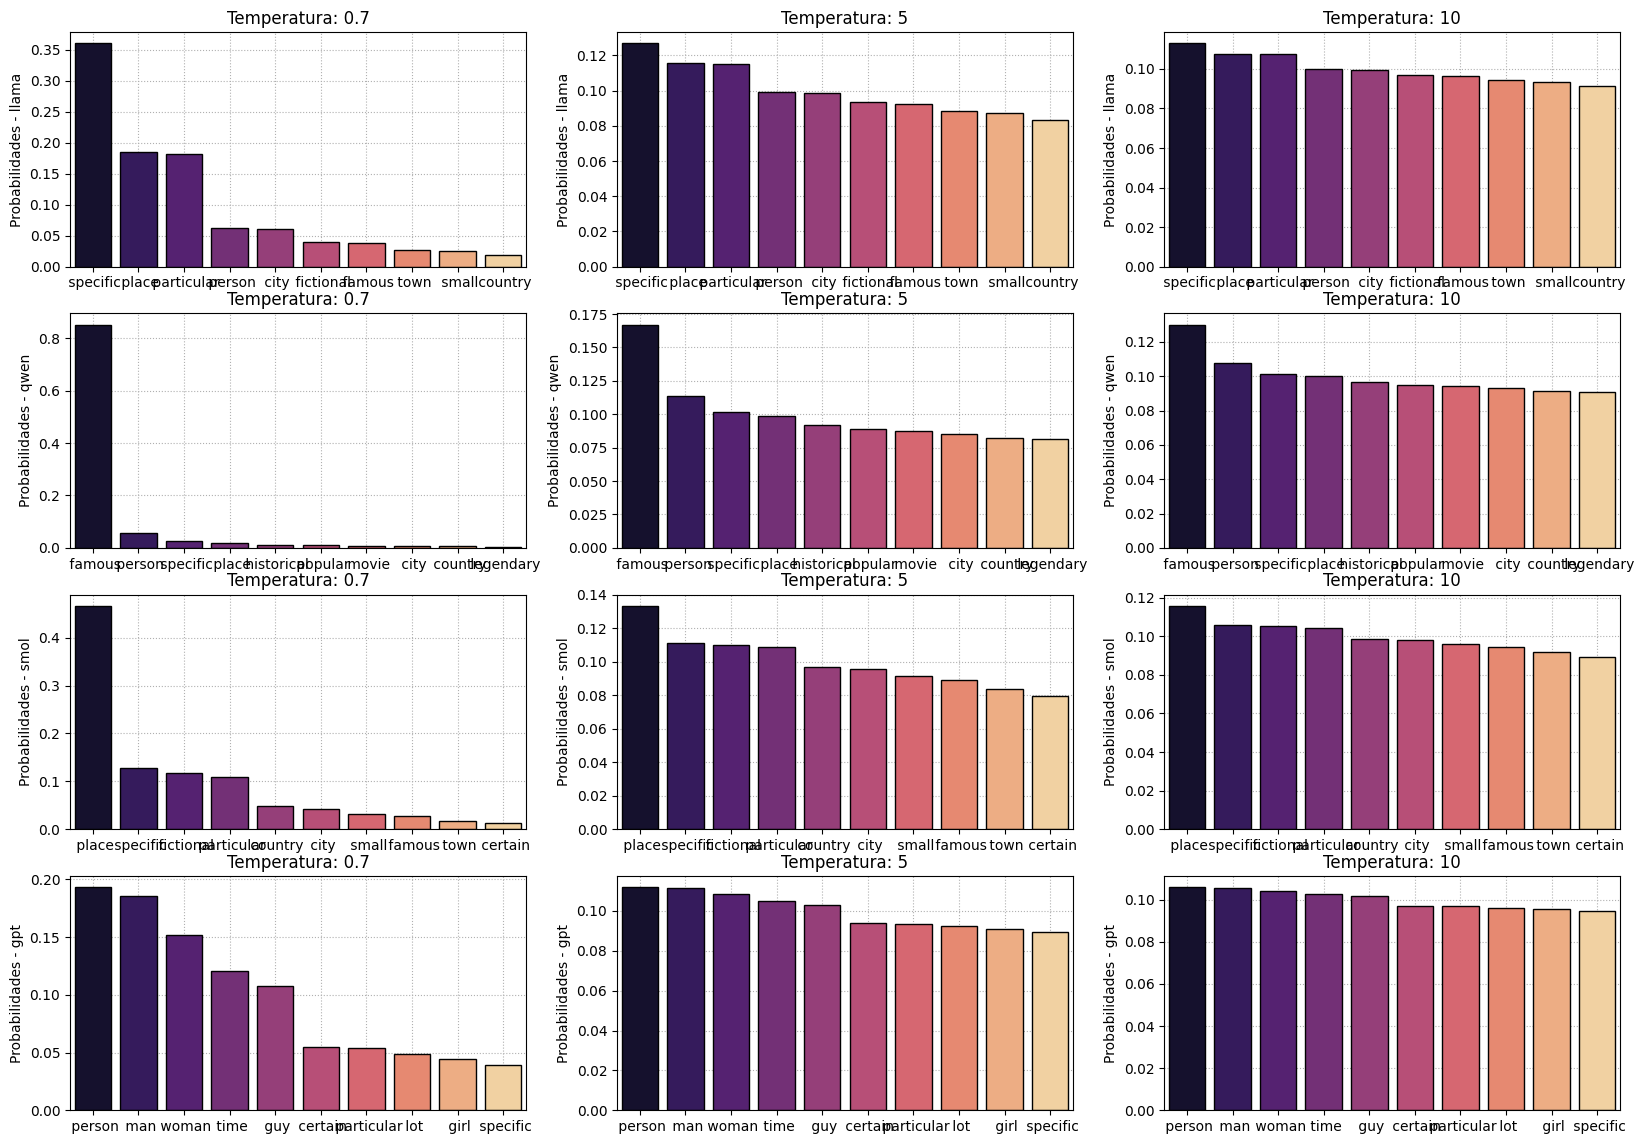

In [ ]:
fig, ax = plt.subplots(nrows=len(models), ncols=3, figsize=(20, 14))

for idx_model, model_name in enumerate(outputs.keys()):
  _, tokenizer = models[model_name]
  last_logits  = outputs[model_name]

  for idx_temp, temp in enumerate([0.7, 5, 10]):
    ax_ = ax[idx_model, idx_temp]
    plot_probabilities(last_logits, tokenizer, model_name, temp=temp, ax=ax_)


Dessa forma, podemos observar que o aumento da temperatura distribui a probabilidade mais igualmente para palavras que antes eram bem menos provaveis de ocorrerem. Enquanto isso, ela diminui a probabilidade de palavras que antes seriam dominantes na predição.


## Gerando Sequências de Tokens

Vamos definir uma função `generate_token` para gerar o próximo token com base nas probabilidades do modelo.

In [ ]:
def generate_token(inputs, model):
    with torch.no_grad():
        outputs = model(**inputs)

    logits        = outputs.logits
    last_logits   = logits[0, -1, :]
    next_token_id = last_logits.argmax()

    return next_token_id

Em seguida, definimos a função `first_input` para preparar a entrada para a geração de sequências de tokens utilizando a predição do modelo de forma sequêncial.

In [ ]:
def first_input(model_name):
  next_inputs = {
      "input_ids": torch.cat(
          [tokens[model_name], next_token_id.reshape((1, 1))],
          dim=1
      ),
      "attention_mask": torch.cat(
          [inputs["attention_mask"], torch.tensor([[1]])],
          dim=1
      ),
  }

  return next_inputs

O código a seguir gera sequências de texto sem usar KV-Cache, medindo o tempo de execução e exibindo os tokens gerados.

In [ ]:

quantidade_tokens = 20
durations_s       = {}
clear_memory()
for model_name in models.keys():
  model, tokenizer        = models[model_name]
  next_inputs             = first_input(model_name)
  generated_tokens        = []
  durations_s[model_name] = []
  clear_memory()


  for _ in range(quantidade_tokens):
      t0            = time.time()
      next_token_id = generate_token(next_inputs, model)

      durations_s[model_name] += [time.time() - t0]

      next_inputs = {
          "input_ids": torch.cat(
              [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
              dim=1),
          "attention_mask": torch.cat(
              [next_inputs["attention_mask"], torch.tensor([[1]])],
              dim=1),
      }

      next_token = tokenizer.decode(next_token_id)
      generated_tokens.append(next_token)
  print('='*30)
  print(f'Modelo        : {model_name}')
  print(f"Tempo total   : {sum(durations_s[model_name])} s")
  print(f"Tokens/s      : {quantidade_tokens/sum(durations_s[model_name])}")
  print(f'Tokens gerados: {generated_tokens}')

Modelo        : llama
Tempo total   : 12.408584117889404 s
Tokens/s      : 1.611787437630864
Tokens gerados: ['cc', 'ane', 'er', ' named', ' Captain', ' Black', 'be', 'ak', ' Betty', '.\n', 'Captain', ' Black', 'be', 'ak', ' Betty', ' was', ' a', ' notorious', ' pirate', ' who']
Modelo        : qwen
Tempo total   : 4.747312545776367 s
Tokens/s      : 4.212909895261433
Tokens gerados: ['on', '.', ' A', 'vel', 'on', ' is', ' a', ' fictional', ' city', ' in', ' the', ' Marvel', ' Comics', ' universe', ',', ' created', ' by', ' writer', ' Stan', ' Lee']
Modelo        : smol
Tempo total   : 3.15503191947937 s
Tokens/s      : 6.339080082365796
Tokens gerados: [' of', ' a', ' business', ' model', ' that', ' is', ' not', ' a', ' traditional', ' business', ' model', '.', '<|im_end|>', '\n', '<|im_start|>', 'ass', 'istant', '\n', 'Here', "'s"]
Modelo        : gpt
Tempo total   : 1.29551100730896 s
Tokens/s      : 15.437923635665644
Tokens gerados: ['-', 'po', ',', ' and', ' I', "'ll", ' tell', '

## Gerando Sequências de Textos usando KV-Cache

Gera sequências de texto usando KV-Cache, medindo o tempo de execução e exibindo os tokens gerados.

In [ ]:
def generate_token_with_past(inputs, model):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [ ]:
quantidade_tokens  = 20
durations_cached_s = {}

for model_name in models.keys():
  model, tokenizer   = models[model_name]
  next_inputs        = first_input(model_name)
  generated_tokens   = []
  clear_memory()

  durations_cached_s[model_name] = []

  for _ in range(quantidade_tokens):
      t0 = time.time()
      next_token_id, past_key_values = \
          generate_token_with_past(next_inputs, model)
      durations_cached_s[model_name] += [time.time() - t0]

      next_inputs = {
          "input_ids": next_token_id.reshape((1, 1)),
          "attention_mask": torch.cat(
              [next_inputs["attention_mask"], torch.tensor([[1]])],
              dim=1),
          "past_key_values": past_key_values,
      }

      next_token = tokenizer.decode(next_token_id)
      generated_tokens.append(next_token)

  print('='*30)
  print(f'Modelo        : {model_name}')
  print(f"Tempo total   : {sum(durations_cached_s[model_name])} s")
  print(f"Tokens/s      : {quantidade_tokens/sum(durations_cached_s[model_name])}")
  print(f'Tokens gerados: {generated_tokens}')

Modelo        : llama
Tempo total   : 5.062213659286499 s
Tokens/s      : 3.9508407479622125
Tokens gerados: [' known', ' as', ' "', 'The', ' Great', ' Fire', ' of', ' London', '"\n', 'The', ' Great', ' Fire', ' of', ' London', ',', ' also', ' known', ' as', ' the', ' Great']
Modelo        : qwen
Tempo total   : 2.531498432159424 s
Tokens/s      : 7.900459169133105
Tokens gerados: [':', ' The', ' story', ' of', ' the', ' first', ' person', ' to', ' be', ' awarded', ' the', ' Nobel', ' Prize', ' in', ' Literature', '.', ' The', ' Nobel', ' Prize', ' in']
Modelo        : smol
Tempo total   : 1.897510051727295 s
Tokens/s      : 10.540128618446099
Tokens gerados: ['inja', ' warrior', ' named', ' K', 'ait', 'o', '**', '\n', '\n', 'K', 'ait', 'o', ' was', ' a', ' legendary', ' n', 'inja', ' warrior', ' from', ' ancient']
Modelo        : gpt
Tempo total   : 0.6520833969116211 s
Tokens/s      : 30.670923527149185
Tokens gerados: ['a', '.', '\n', '\n', 'A', 'rain', 'a', ' is', ' a', ' native', 

### Comparando a Performance

Agora vamos comparar o desempenho das gerações sem cache e com KV-Cache.

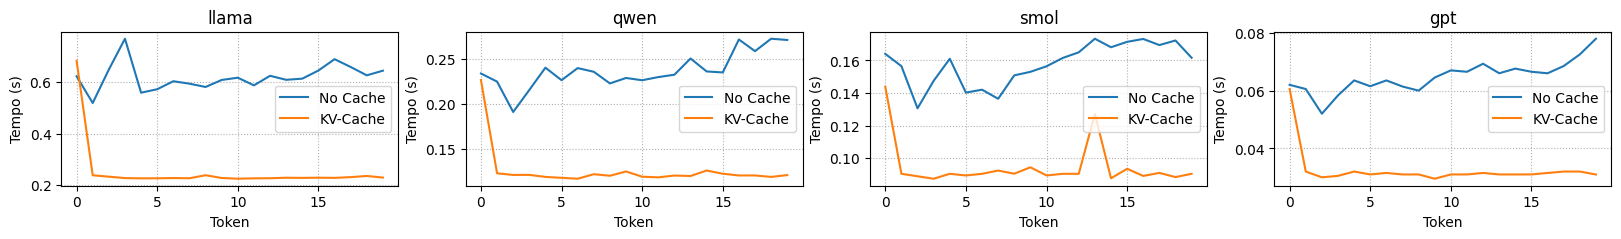

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 2), sharey=False)

for idx_model, model_name in enumerate(models.keys()):
  sns.lineplot(durations_s[model_name], ax=ax[idx_model], label='No Cache')
  sns.lineplot(durations_cached_s[model_name], ax=ax[idx_model], label='KV-Cache')
  ax[idx_model].set_title(model_name)
  ax[idx_model].set_xlabel('Token')
  ax[idx_model].set_ylabel('Tempo (s)')
  ax[idx_model].grid(True, linestyle=':')
  ax[idx_model].set_axisbelow(True)


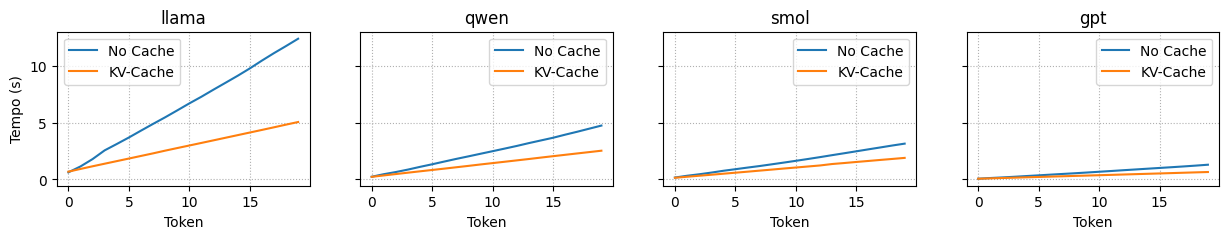

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(models), figsize=(15, 2), sharey=True)

for idx_model, model_name in enumerate(models.keys()):
  sns.lineplot(np.cumsum(durations_s[model_name]), ax=ax[idx_model], label='No Cache')
  sns.lineplot(np.cumsum(durations_cached_s[model_name]), ax=ax[idx_model], label='KV-Cache')
  ax[idx_model].set_title(model_name)
  ax[idx_model].set_xlabel('Token')
  ax[idx_model].set_ylabel('Tempo (s)')
  ax[idx_model].grid(True, linestyle=':')
  ax[idx_model].set_axisbelow(True)